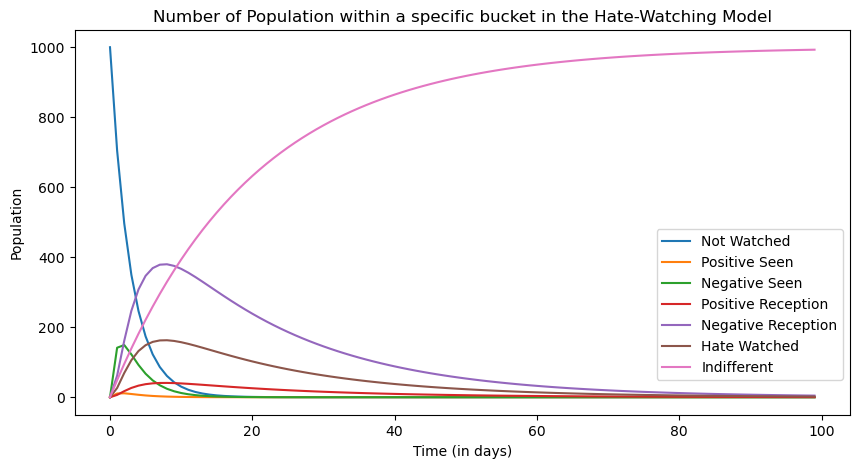

Peak Positive Seen:  11.22594739213565
Peak Day:  2
Peak Negative Seen:  149.1447296383736
Peak Day:  2

Peak Positive Reception:  40.84936561906048
Peak Day:  8
Peak Negative Reception:  379.89910025726243
Peak Day:  8
Peak HateWatched Reception:  162.8139001102553
Peak Day:  8

Peak Indifference Reception:  992.916590071821
Peak Day:  99


In [29]:
import json
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

t_end = 100
t = np.arange(0, t_end, 1)

# Parameters
with open('params.json', 'r') as f: 
    parameters = json.loads(f.read())

# Initial Condition
NW0 = parameters['Initial Population']

PR0 = 0         # Amount of People who have seen mostly positive reviews about the movie
NR0 = 0         # Amount of People who have seen mostly negative reviews about the movie

PN0 = (parameters["Initial Score"]/parameters["Score Max"]) * parameters["Initial Number Reviews"]       # Amount of Initial Positive Reviews
NN0 = parameters["Initial Number Reviews"] - PN0                                     # Amount of Initial Negative Reviews

prob_liking = (parameters["Initial Score"]/parameters["Score Max"])

PP0 = 0         # Amount of People who have seriously positive reception
NP0 = 0         # Amount of People who have seriously negative reception
HW0 = 0         # Amount of People who have hate-watched

I0 = 0          # Amount of People who have become indifferent

# ODE System
def model(t, y):
    NW, PR, NR, PP, NP, HW, I, PN, NN = y
    dNWdt = -NW*parameters['Prob Seeing Review'] - parameters['Prob Indifference']*NW

    dPRdt = (PN/(PN+NN))*parameters['Prob Seeing Review']*NW - PR - parameters['Prob Indifference']*PR
    dNRdt = (NN/(PN+NN))*parameters['Prob Seeing Review']*NW - NR - parameters['Prob Indifference']*NR

    dPPdt = prob_liking*(PR+NR) - parameters['Prob Indifference']*PP 
    dNPdt = (1-prob_liking)*(1-parameters['Prob Hate Watching'])*(PR+NR) - parameters['Prob Indifference']*NP
    dHWdt = (1-prob_liking)*(parameters['Prob Hate Watching'])*(PR+NR) - parameters['Prob Indifference']*HW

    dIdt = parameters['Prob Indifference']*(NW+PR+NR+PP+NP+HW)

    # Change in Review Count
    dPNdt = parameters["Review Rate"] * PP
    dNNdt = parameters["Review Rate"] * (NP+HW)


    return [dNWdt, dPRdt, dNRdt, dPPdt, dNPdt, dHWdt, dIdt, dPNdt, dNNdt]


sol = solve_ivp(model, [t[0], t[-1]], [NW0, PR0, NR0, PP0, NP0, HW0, I0, PN0, NN0], t_eval=t)

plt.figure(figsize=(10, 5))
plt.plot(t, sol.y[0], label="Not Watched")

plt.plot(t, sol.y[1], label="Positive Seen")
plt.plot(t, sol.y[2], label="Negative Seen")

plt.plot(t, sol.y[3], label="Positive Reception")
plt.plot(t, sol.y[4], label="Negative Reception")
plt.plot(t, sol.y[5], label="Hate Watched")

plt.plot(t, sol.y[6], label="Indifferent")

# plt.plot(t, sol.y[7] + sol.y[8], label="Number Reviews")

plt.xlabel("Time (in days)")
plt.ylabel("Population")
plt.title("Number of Population within a specific bucket in the Hate-Watching Model")
plt.legend(bbox_to_anchor=(1, 0.5))
plt.show()

print("Peak Positive Seen: ", sol.y[1].max())
print("Peak Day: ", t[sol.y[1].argmax()])

print("Peak Negative Seen: ", sol.y[2].max())
print("Peak Day: ", t[sol.y[2].argmax()])

print()

print("Peak Positive Reception: ", sol.y[3].max())
print("Peak Day: ", t[sol.y[3].argmax()])

print("Peak Negative Reception: ", sol.y[4].max())
print("Peak Day: ", t[sol.y[4].argmax()])

print("Peak HateWatched Reception: ", sol.y[5].max())
print("Peak Day: ", t[sol.y[5].argmax()])

print()

print("Peak Indifference Reception: ", sol.y[6].max())
print("Peak Day: ", t[sol.y[6].argmax()])